# Ad-Gen-Pipeline Validation Notebook

This notebook validates each step of the advertisement image generation pipeline:
1. **Object Matting**: Remove background from product image
2. **Background Generation**: Create atmospheric background
3. **Spatial Analysis**: Find optimal placement location
4. **Object Synthesis**: Blend object into background with natural lighting

## Cell 1: Environment Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from helper_dev_utils import get_auto_logger
logger = get_auto_logger()

2026-01-06 21:15:14 W [helper_utils_colab:211] - GoogleDrive not found, falling back to temp folder: /tmp
2026-01-06 21:15:14 W [helper_utils_colab:122] - Cache directory not found, falling back to temp folder: /tmp


In [3]:
# Import libraries
import sys
from pathlib import Path
import torch
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display

# Add parent directory to path
sys.path.append(str(Path.cwd().parent))

# Import our modules
from src import (
    flush_gpu,
    load_image,
    save_image,
    ObjectMatting,
    BackgroundGenerator,
    SpatialAnalyzer,
    ObjectSynthesizer
)
from src.utils import get_device, print_gpu_memory

# Check GPU availability
device = get_device()
print_gpu_memory()

# Helper function to display images
def show_images(images, titles=None, figsize=(15, 5)):
    """Display multiple images side by side."""
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1:
        axes = [axes]
    
    for i, (img, ax) in enumerate(zip(images, axes)):
        ax.imshow(img)
        ax.axis('off')
        if titles and i < len(titles):
            ax.set_title(titles[i])
    
    plt.tight_layout()
    plt.show()

logger.debug("\n✅ Environment setup complete!")

✓ 사용 디바이스: cuda (NVIDIA L4)
  사용 가능 VRAM: 22.03 GB
  GPU 메모리 - 할당됨: 0.00 GB, 예약됨: 0.00 GB
2026-01-06 21:15:25 D [ipykernel_launcher:45] - 
✅ Environment setup complete!


## Cell 2: Input Data Definition (User Scenario)

In [4]:
# ==================================================
# USER CONFIGURATION: Modify these parameters
# ==================================================

# Input product image path
INPUT_IMAGE_PATH = "../image.png"  # 노가리 이미지

# Scenario: 노가리를 술안주로 제공하는 포장마차/선술집 장면
PROMPT_SCENARIO = (
    "A photorealistic shot of dried pollack fish (nogari) as a Korean bar snack "
    "on a wooden table in a traditional Korean bar (pojangmacha), "
    "warm ambient lighting, cozy atmosphere, shallow depth of field, "
    "natural food photography, cinematic style"
)

# Background-specific prompt (remove product mentions)
PROMPT_BACKGROUND = (
    "An empty wooden table in a cozy Korean traditional bar (pojangmacha) "
    "with soft warm lighting, empty space in center for food placement, "
    "blurred background showing bar atmosphere with bokeh effect, "
    "shallow depth of field, warm tones, no food on table"
)

# Spatial query for object placement
SPATIAL_QUERY = (
    "Find the flat surface on the table center where I can place dried fish snacks. "
    "Return the bounding box coordinates for the empty area."
)

# Generation parameters
IMAGE_SIZE = (1024, 1024)  # (width, height)
SEED = 42  # For reproducibility
IP_ADAPTER_SCALE = 0.8  # 0.7=natural, 1.0=preserve original

# Output directory
OUTPUT_DIR = Path("../outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

logger.debug("📋 Configuration:")
print(f"   Input: {INPUT_IMAGE_PATH}")
print(f"   Output: {OUTPUT_DIR}")
print(f"   Image size: {IMAGE_SIZE}")
print(f"   Seed: {SEED}")
print(f"\n💭 Scenario: {PROMPT_SCENARIO}")

2026-01-06 21:15:26 D [ipykernel_launcher:39] - 📋 Configuration:
   Input: ../image.png
   Output: ../outputs
   Image size: (1024, 1024)
   Seed: 42

💭 Scenario: A photorealistic shot of dried pollack fish (nogari) as a Korean bar snack on a wooden table in a traditional Korean bar (pojangmacha), warm ambient lighting, cozy atmosphere, shallow depth of field, natural food photography, cinematic style


## Cell 3: Step 1 - Object Matting (Background Removal)

Remove the background from the product image to create a clean reference.

2026-01-06 21:15:26 D [ipykernel_launcher:1] - 🔄 Step 1: Object Matting (Background Removal)

2026-01-06 21:15:26 D [ipykernel_launcher:2] - ============================================================
✓ 이미지 로드 완료: image.png (750x750, RGB)

Original image loaded: (750, 750)
🔧 ObjectMatting 초기화: ZhengPeng7/BiRefNet
  BiRefNet 모델을 cuda에 로드 중...


/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


  ✓ BiRefNet 모델 로드 완료
✓ 이미지 로드 완료: image.png (750x750, RGB)
  배경 제거 실행 중...
  ✓ 배경 제거 완료 (RGBA)
  BiRefNet 모델 언로드 중...
✓ GPU 메모리 정리 완료
✓ 이미지 저장 완료: step1_clean_reference.png
2026-01-06 21:15:33 D [ipykernel_launcher:22] - 
📊 Validation Point: Is the background cleanly removed?


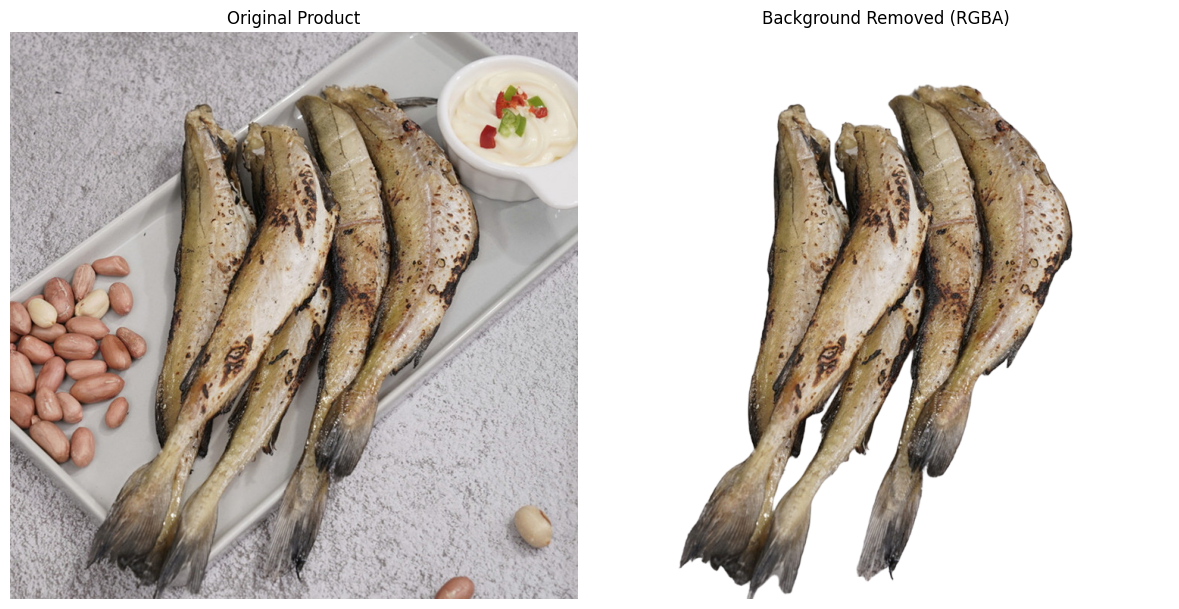

✓ GPU 메모리 정리 완료
  GPU 메모리 - 할당됨: 0.01 GB, 예약됨: 0.05 GB
2026-01-06 21:15:34 D [ipykernel_launcher:33] - 
✅ Step 1 complete!



In [5]:
logger.debug("🔄 Step 1: Object Matting (Background Removal)\n")
logger.debug("=" * 60)

# Load original image
original_image = load_image(INPUT_IMAGE_PATH)
print(f"\nOriginal image loaded: {original_image.size}")

# Initialize ObjectMatting
matting = ObjectMatting()

# Remove background
clean_ref_image = matting.remove_background(
    INPUT_IMAGE_PATH,
    return_rgba=True
)

# Save result
output_path = OUTPUT_DIR / "step1_clean_reference.png"
save_image(clean_ref_image, output_path)

# Display results
logger.debug("\n📊 Validation Point: Is the background cleanly removed?")
show_images(
    [original_image, clean_ref_image],
    titles=["Original Product", "Background Removed (RGBA)"],
    figsize=(12, 6)
)

# Memory cleanup
del matting
flush_gpu()
print_gpu_memory()
logger.debug("\n✅ Step 1 complete!\n")

## Cell 4: Step 2 - Background Generation

Generate an atmospheric background without the product.

2026-01-06 21:15:39 D [ipykernel_launcher:1] - 🔄 Step 2: Background Generation

2026-01-06 21:15:39 D [ipykernel_launcher:2] - ============================================================
🔧 BackgroundGenerator 초기화: black-forest-labs/FLUX.1-dev
  FLUX.1-dev 파이프라인을 cuda에 로드 중...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
The module 'CLIPTextModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.
The module 'T5EncoderModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.
The module 'AutoencoderKL' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


  ✓ FLUX.1-dev 파이프라인 로드 완료 (8bit 양자화)
  배경 생성 중 (1024x1024)...
  프롬프트: An empty wooden table in a cozy Korean traditional bar (pojangmacha) with soft w...


/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


  0%|          | 0/28 [00:00<?, ?it/s]

The module 'CLIPTextModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.
The module 'T5EncoderModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.
The module 'AutoencoderKL' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


  ✓ 배경 생성 완료
  FLUX.1-dev 파이프라인 언로드 중...
✓ GPU 메모리 정리 완료
✓ 이미지 저장 완료: step2_background.png
2026-01-06 21:19:44 D [ipykernel_launcher:22] - 
📊 Validation Point: Does the background have space for object placement?


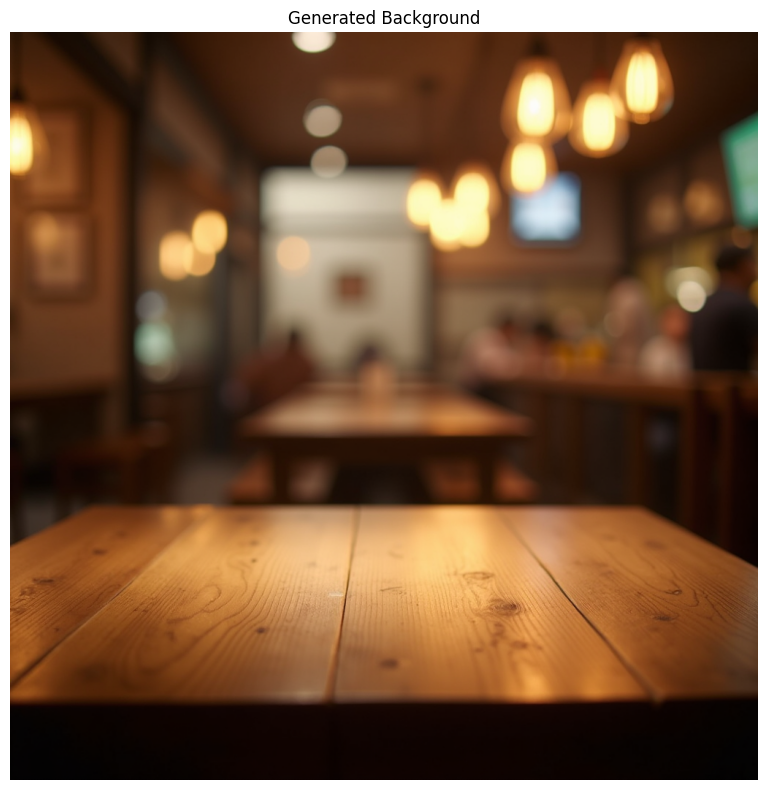

✓ GPU 메모리 정리 완료
  GPU 메모리 - 할당됨: 0.01 GB, 예약됨: 0.05 GB
2026-01-06 21:19:45 D [ipykernel_launcher:33] - 
✅ Step 2 complete!



In [6]:
logger.debug("🔄 Step 2: Background Generation\n")
logger.debug("=" * 60)

# Initialize BackgroundGenerator
bg_generator = BackgroundGenerator()

# Generate background
bg_image = bg_generator.generate_background(
    prompt=PROMPT_BACKGROUND,
    width=IMAGE_SIZE[0],
    height=IMAGE_SIZE[1],
    num_inference_steps=28,
    guidance_scale=3.5,
    seed=SEED
)

# Save result
output_path = OUTPUT_DIR / "step2_background.png"
save_image(bg_image, output_path)

# Display result
logger.debug("\n📊 Validation Point: Does the background have space for object placement?")
show_images(
    [bg_image],
    titles=["Generated Background"],
    figsize=(8, 8)
)

# Memory cleanup
del bg_generator
flush_gpu()
print_gpu_memory()
logger.debug("\n✅ Step 2 complete!\n")

## Cell 5: Step 3 - Spatial Analysis (Object Placement)

Analyze the background to find the optimal location for object placement.

In [ ]:
logger.debug("🔄 Step 3: Spatial Analysis (Object Placement)\n")
logger.debug("=" * 60)

# Initialize SpatialAnalyzer
analyzer = SpatialAnalyzer()

# Detect optimal surface
detection_result = analyzer.detect_surface(
    image=bg_image,
    query=SPATIAL_QUERY
)

bbox = detection_result['bbox']
print(f"\n📍 Detected bounding box: {bbox}")
print(f"   Model response: {detection_result['text'][:150]}...")

# Create mask
mask_image = analyzer.create_mask(
    image_size=detection_result['image_size'],
    bbox=bbox
)

# Save mask
output_path = OUTPUT_DIR / "step3_mask.png"
save_image(mask_image, output_path)

# Visualize bbox on background
bg_with_bbox = analyzer.visualize_bbox(
    image=bg_image,
    bbox=bbox,
    color='red',
    width=5
)

# Display results
logger.debug("\n📊 Validation Point: Is the mask positioned appropriately?")
show_images(
    [bg_image, bg_with_bbox, mask_image],
    titles=["Background", "With BBox", "Binary Mask"],
    figsize=(18, 6)
)

# Memory cleanup
del analyzer
flush_gpu()
print_gpu_memory()
logger.debug("\n✅ Step 3 complete!\n")

2026-01-06 21:19:53 D [ipykernel_launcher:1] - 🔄 Step 3: Spatial Analysis (Object Placement)

2026-01-06 21:19:53 D [ipykernel_launcher:2] - ============================================================
🔧 SpatialAnalyzer 초기화: Qwen/Qwen2-VL-7B-Instruct
  Qwen2-VL 모델을 cuda에 로드 중...


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

## Cell 6: Step 4 - Object Synthesis (Final Composition)

Synthesize the clean object into the background with natural lighting and shadows.

In [ ]:
logger.debug("🔄 Step 4: Object Synthesis (Final Composition)\n")
logger.debug("=" * 60)

# Initialize ObjectSynthesizer
synthesizer = ObjectSynthesizer()

# Synthesize object into background
final_image = synthesizer.fill_in_object(
    background=bg_image,
    mask=mask_image,
    reference=clean_ref_image,
    prompt=PROMPT_SCENARIO,
    num_inference_steps=28,
    guidance_scale=3.5,
    ip_adapter_scale=IP_ADAPTER_SCALE,
    seed=SEED
)

# Save final result
output_path = OUTPUT_DIR / "step4_final_result.png"
save_image(final_image, output_path)

# Display final comparison
logger.debug("\n📊 Validation Point: Is the object naturally blended with proper lighting/shadows?")
show_images(
    [clean_ref_image, bg_image, mask_image, final_image],
    titles=["Clean Reference", "Background", "Mask", "Final Result"],
    figsize=(20, 5)
)

# Show before/after comparison
logger.debug("\n🔍 Before/After Comparison:")
show_images(
    [bg_image, final_image],
    titles=["Background Only", "With Product"],
    figsize=(16, 8)
)

# Memory cleanup
del synthesizer
flush_gpu()
print_gpu_memory()
logger.debug("\n✅ Step 4 complete!\n")

## Cell 7: Full Pipeline Integration

Run the entire pipeline end-to-end in a single function.

In [ ]:
def run_full_pipeline(
    input_image_path,
    prompt_scenario,
    prompt_background,
    spatial_query,
    image_size=(1024, 1024),
    ip_adapter_scale=0.8,
    seed=None,
    output_dir=None
):
    """
    Execute the complete Ad-Gen-Pipeline.
    
    Returns:
        dict: Dictionary containing all intermediate and final images
    """
    logger.debug("🚀 Starting Full Pipeline Execution\n")
    logger.debug("=" * 70)
    
    results = {}
    
    # Setup output directory
    if output_dir is None:
        output_dir = Path("../outputs/pipeline_run")
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # ============================================
    # Step 1: Object Matting
    # ============================================
    logger.debug("\n[1/4] Object Matting...")
    matting = ObjectMatting()
    clean_ref = matting.remove_background(input_image_path, return_rgba=True)
    save_image(clean_ref, output_dir / "1_clean_reference.png")
    results['clean_reference'] = clean_ref
    del matting
    flush_gpu()
    
    # ============================================
    # Step 2: Background Generation
    # ============================================
    logger.debug("\n[2/4] Background Generation...")
    bg_gen = BackgroundGenerator()
    background = bg_gen.generate_background(
        prompt=prompt_background,
        width=image_size[0],
        height=image_size[1],
        seed=seed
    )
    save_image(background, output_dir / "2_background.png")
    results['background'] = background
    del bg_gen
    flush_gpu()
    
    # ============================================
    # Step 3: Spatial Analysis
    # ============================================
    logger.debug("\n[3/4] Spatial Analysis...")
    analyzer = SpatialAnalyzer()
    detection = analyzer.detect_surface(background, spatial_query)
    mask = analyzer.create_mask(detection['image_size'], detection['bbox'])
    save_image(mask, output_dir / "3_mask.png")
    results['mask'] = mask
    results['bbox'] = detection['bbox']
    del analyzer
    flush_gpu()
    
    # ============================================
    # Step 4: Object Synthesis
    # ============================================
    logger.debug("\n[4/4] Object Synthesis...")
    synthesizer = ObjectSynthesizer()
    final = synthesizer.fill_in_object(
        background=background,
        mask=mask,
        reference=clean_ref,
        prompt=prompt_scenario,
        ip_adapter_scale=ip_adapter_scale,
        seed=seed
    )
    save_image(final, output_dir / "4_final_result.png")
    results['final'] = final
    del synthesizer
    flush_gpu()
    
    logger.debug("\n" + "=" * 70)
    logger.debug("✅ Pipeline Execution Complete!")
    print(f"   Results saved to: {output_dir}")
    
    return results


# ============================================
# Execute Full Pipeline
# ============================================

pipeline_results = run_full_pipeline(
    input_image_path=INPUT_IMAGE_PATH,
    prompt_scenario=PROMPT_SCENARIO,
    prompt_background=PROMPT_BACKGROUND,
    spatial_query=SPATIAL_QUERY,
    image_size=IMAGE_SIZE,
    ip_adapter_scale=IP_ADAPTER_SCALE,
    seed=SEED,
    output_dir=OUTPUT_DIR / "full_pipeline"
)

# Display all results
logger.debug("\n🎨 Pipeline Results:")
show_images(
    [
        load_image(INPUT_IMAGE_PATH),
        pipeline_results['clean_reference'],
        pipeline_results['background'],
        pipeline_results['mask'],
        pipeline_results['final']
    ],
    titles=["Original", "Clean Ref", "Background", "Mask", "Final Result"],
    figsize=(25, 5)
)

logger.debug("\n🎉 All validations complete!")

## Optional: Parameter Tuning Experiments

Test different IP-Adapter scales to find the optimal balance.

In [ ]:
# Experiment with different IP-Adapter scales
logger.debug("🧪 IP-Adapter Scale Comparison Experiment\n")

scales_to_test = [0.6, 0.8, 1.0]
comparison_results = []

synthesizer = ObjectSynthesizer()

for scale in scales_to_test:
    print(f"\nTesting IP-Adapter scale: {scale}")
    
    result = synthesizer.fill_in_object(
        background=bg_image,
        mask=mask_image,
        reference=clean_ref_image,
        prompt=PROMPT_SCENARIO,
        ip_adapter_scale=scale,
        seed=SEED
    )
    
    comparison_results.append(result)
    save_image(result, OUTPUT_DIR / f"comparison_scale_{scale}.png")

del synthesizer
flush_gpu()

# Display comparison
logger.debug("\n📊 Comparison: Different IP-Adapter Scales")
show_images(
    comparison_results,
    titles=[f"Scale {s} ({'Natural' if s == 0.6 else 'Balanced' if s == 0.8 else 'Preserve'})" 
            for s in scales_to_test],
    figsize=(18, 6)
)

logger.debug("\n💡 Recommendation:")
logger.debug("   • Scale 0.6-0.7: More natural blending, less original preservation")
logger.debug("   • Scale 0.8: Good balance (recommended)")
logger.debug("   • Scale 1.0: Maximum original preservation, may look less natural")